<a href="https://colab.research.google.com/github/tensorflow/tensorrt/blob/r2.0/tftrt/examples/image_classification/TFv2-TF-TRT-inference-from-Keras-saved-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="https://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_tftrt_ptq/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with TensorFlow 2.0


## Introduction
The NVIDIA TensorRT is a C++ library that facilitates high performance inference on NVIDIA graphics processing units (GPUs). TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine which performs inference for that network. 

TensorFlow™ integration with TensorRT™ (TF-TRT) optimizes and executes compatible subgraphs, allowing TensorFlow to execute the remaining graph. While you can still use TensorFlow's wide and flexible feature set, TensorRT will parse the model and apply optimizations to the portions of the graph wherever possible.

In this notebook, we demonstrate the process of optimizing a ResNet-50 model with a TF-TRT.

## Requirement

### GPU

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 and INT8 inference, a Volta, Turing, Ampere or newer generation GPU with Tensor cores is desired.

In [1]:
!nvidia-smi

Thu Mar 31 19:17:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   36C    P8    21W / 300W |      0MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:41:00.0 Off |                    0 |
|  0%   

### Install Dependencies

In [2]:
!pip install pillow matplotlib

### Importing required libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [4]:
 print("Tensorflow version: ", tf.version.VERSION)

# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

Tensorflow version:  2.8.0
TensorRT version: 
ii  libnvinfer-bin                    8.2.3-1+cuda11.4                  amd64        TensorRT binaries
ii  libnvinfer-dev                    8.2.3-1+cuda11.4                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev             8.2.3-1+cuda11.4                  amd64        TensorRT plugin libraries and headers
ii  libnvinfer-plugin8                8.2.3-1+cuda11.4                  amd64        TensorRT plugin library
ii  libnvinfer8                       8.2.3-1+cuda11.4                  amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorRT version: 
ii  libnvinfer5   5.1.5-1+cuda10.1   amd64        TensorRT runtime libraries
```

### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [5]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


2022-03-31 19:17:23.701113: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 19:17:25.283578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:17:25.284562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:17:25.285309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 43436 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute cap

## Data
We download several random images for testing from the Internet.

In [6]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2022-03-31 19:17:26--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 18.65.227.127, 18.65.227.223, 18.65.227.37, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|18.65.227.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.003s  

2022-03-31 19:17:26 (7.46 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2022-03-31 19:17:26--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

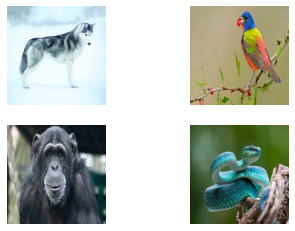

In [7]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

## Model

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [8]:
model = ResNet50(weights='imagenet')

2022-03-31 19:17:32.048652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:17:32.049153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:17:32.049637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43436 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-03-31 19:17:32.050111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 43436 MB memory:  -> device: 3, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


Before proceeding, let's quick take a look at the predictions

2022-03-31 19:17:35.279115: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8303
2022-03-31 19:17:36.772709: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5571331), ('n02109961', 'Eskimo_dog', 0.41630116), ('n02110063', 'malamute', 0.021332687)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.301645), ('n01537544', 'indigo_bunting', 0.16954009), ('n01828970', 'bee_eater', 0.16138536)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5103813), ('n02480495', 'orangutan', 0.16043848), ('n02480855', 'gorilla', 0.1509965)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.4083977), ('n03627232', 'knot', 0.09960673), ('n01749939', 'green_mamba', 0.06695716)]


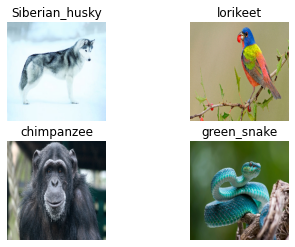

In [9]:
for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])
    

In [11]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

2022-03-31 19:17:50.289205: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [10]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: T

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

### Benchmarking Inference with native TF2.0 saved model

In [12]:
model = tf.keras.models.load_model('resnet50_saved_model')

In [13]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [14]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 53.9ms
Step 50: 54.3ms
Step 100: 54.4ms
Step 150: 53.6ms
Step 200: 53.5ms
Step 250: 53.8ms
Step 300: 53.5ms
Step 350: 53.7ms
Step 400: 53.6ms
Step 450: 60.1ms
Step 500: 55.4ms
Step 550: 55.1ms
Step 600: 54.8ms
Step 650: 54.7ms
Step 700: 54.5ms
Step 750: 54.2ms
Step 800: 53.6ms
Step 850: 53.7ms
Step 900: 53.9ms
Step 950: 54.0ms
Throughput: 147 images/s


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [15]:
print('Converting to TF-TRT FP32...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP32,
                                    max_workspace_size_bytes=8000000000)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


2022-03-31 19:19:13.215168: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-03-31 19:19:13.215301: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-03-31 19:19:13.266148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:19:13.266661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:19:13.267135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43436 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [16]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          input_1: TensorSp

Before proceeding, let's write a couple of utility functions to use the model for prediction and benchmarking purposes.

In [17]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['predictions'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [18]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


2022-03-31 19:19:46.675549: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-03-31 19:19:46.682518: I tensorflow/compiler/tf2tensorrt/common/utils.cc:100] Linked TensorRT version: 8.2.3
2022-03-31 19:19:46.682690: I tensorflow/compiler/tf2tensorrt/common/utils.cc:102] Loaded TensorRT version: 8.2.3
2022-03-31 19:19:47.748477: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1372] [TF-TRT] Sparse compute capability is enabled.
2022-03-31 19:19:47.750009: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5569863), ('n02109961', 'Eskimo_dog', 0.41644078), ('n02110063', 'malamute', 0.021332804)]


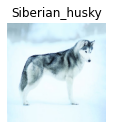

In [19]:
predict_tftrt('resnet50_saved_model_TFTRT_FP32')

Next, we load and test the TF-TRT FP32 model.

In [20]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

2022-03-31 19:20:15.711311: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-03-31 19:20:16.363793: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


Step 0:  4.0ms
Step 50:  4.0ms
Step 100:  4.0ms
Step 150:  4.0ms
Step 200:  4.0ms
Step 250:  4.0ms
Step 300:  4.0ms
Step 350:  4.0ms
Step 400:  4.0ms
Step 450:  4.0ms
Step 500:  4.0ms
Step 550:  4.0ms
Step 600:  4.0ms
Step 650:  4.0ms
Step 700:  4.0ms
Step 750:  4.0ms
Step 800:  4.0ms
Step 850:  4.0ms
Step 900:  4.0ms
Step 950:  4.0ms
Throughput: 1985 images/s


### TF-TRT FP16 model
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

In [21]:
print('Converting to TF-TRT FP16...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP16,
                                    max_workspace_size_bytes=8000000000)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


2022-03-31 19:20:40.435280: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-03-31 19:20:40.435397: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-03-31 19:20:40.443801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:20:40.444278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:20:40.444748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43436 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


INFO:tensorflow:Could not find TRTEngineOp_1_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


2022-03-31 19:20:59.847894: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-03-31 19:21:00.426191: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5570198), ('n02109961', 'Eskimo_dog', 0.41618717), ('n02110063', 'malamute', 0.021451887)]


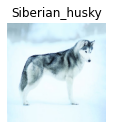

In [22]:
predict_tftrt('resnet50_saved_model_TFTRT_FP16')

In [23]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

2022-03-31 19:21:52.622013: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-03-31 19:21:53.272943: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


Step 0:  1.4ms
Step 50:  1.8ms
Step 100:  1.9ms
Step 150:  1.8ms
Step 200:  1.9ms
Step 250:  1.8ms
Step 300:  1.8ms
Step 350:  1.8ms
Step 400:  1.8ms
Step 450:  1.8ms
Step 500:  1.9ms
Step 550:  1.8ms
Step 600:  1.8ms
Step 650:  1.8ms
Step 700:  1.8ms
Step 750:  1.8ms
Step 800:  1.8ms
Step 850:  1.8ms
Step 900:  1.9ms
Step 950:  1.7ms
Throughput: 4388 images/s


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

Herein, for demonstration purposes, we take only the 4 images that we downloaded for calibration. In production, this set should be more representative of the production data.

In [ ]:
import os
os.kill(os.getpid(), 9)

Adding data loading and util functions again from above for to ease the notebook flow after reseting the kernel.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


2022-03-31 19:22:50.687672: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 19:22:52.061051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:22:52.062051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:22:52.062771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2

In [3]:
def calibration_input_fn():
    yield (batched_input, )

print('Converting to TF-TRT INT8...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.INT8,
                                    max_workspace_size_bytes=8000000000)

converter.convert(calibration_input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


2022-03-31 19:22:58.090840: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-03-31 19:22:58.090987: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-03-31 19:22:58.140049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43436 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-31 19:22:58.140553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43436 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-31 19:22:58.141027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43436 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets
Done Converting to TF-TRT INT8


In [4]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['predictions'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [5]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5626333), ('n02109961', 'Eskimo_dog', 0.4116313), ('n02110063', 'malamute', 0.02198676)]


2022-03-31 19:24:46.535802: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ


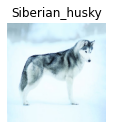

In [6]:
predict_tftrt('resnet50_saved_model_TFTRT_INT8')

In [7]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

2022-03-31 19:24:51.421224: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ


Step 0:  2.2ms
Step 50:  1.8ms
Step 100:  1.7ms
Step 150:  1.8ms
Step 200:  1.8ms
Step 250:  1.7ms
Step 300:  1.7ms
Step 350:  1.8ms
Step 400:  1.8ms
Step 450:  1.6ms
Step 500:  1.4ms
Step 550:  1.4ms
Step 600:  1.5ms
Step 650:  1.3ms
Step 700:  1.4ms
Step 750:  1.9ms
Step 800:  1.9ms
Step 850:  1.9ms
Step 900:  1.8ms
Step 950:  1.8ms
Throughput: 4746 images/s


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy. 

### What's next
Try TF-TRT on your own model and data, and experience the simplicity and speed up it offers.